# 学習の目標
- 転移学習の概要について理解する
- 自作モデルと転移学習のモデルの比較を行い転移学習のメリットを把握する

## 事前準備
-  このチュートリアルではGPUを用いて処理を行うために、上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUに設定して下さい

In [ ]:
# GPUの確認(出力結果がcpuになった場合は上記の手順でランタイムをGPUに変更して下さい)
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# 転移学習とは

深層学習において、高品質なデータを大量に取得することは現実的に難しい場合が多く、  
例えばデータはあるがラベル付けするをするアノテーション作業に莫大な時間や労力がかかるケースが挙げられます。  

こうした課題を解決するための手法として、転移学習があります。  
転移学習とは大規模なデータセットで学習したパラメータを初期パラメータとして、別の（小規模な）データセットを用いて学習を行う方法を指します。  
転移学習を使用することで、既存の知識を活用し、少量のデータからも高精度なモデルを短時間で学習することが可能となります。  

特に、ImageNetのような大規模なデータセットで事前に学習したモデルの知識を活用することが多く、元にしたモデルに追加した層のみを学習することを転移学習、事前学習の重みを基にネットワーク全体を学習することをファインチューニングと呼びます。  
このようなアプローチを取ることで、データが限られている場面や学習時間を短縮したい場合に効果的な学習を実現することができます。

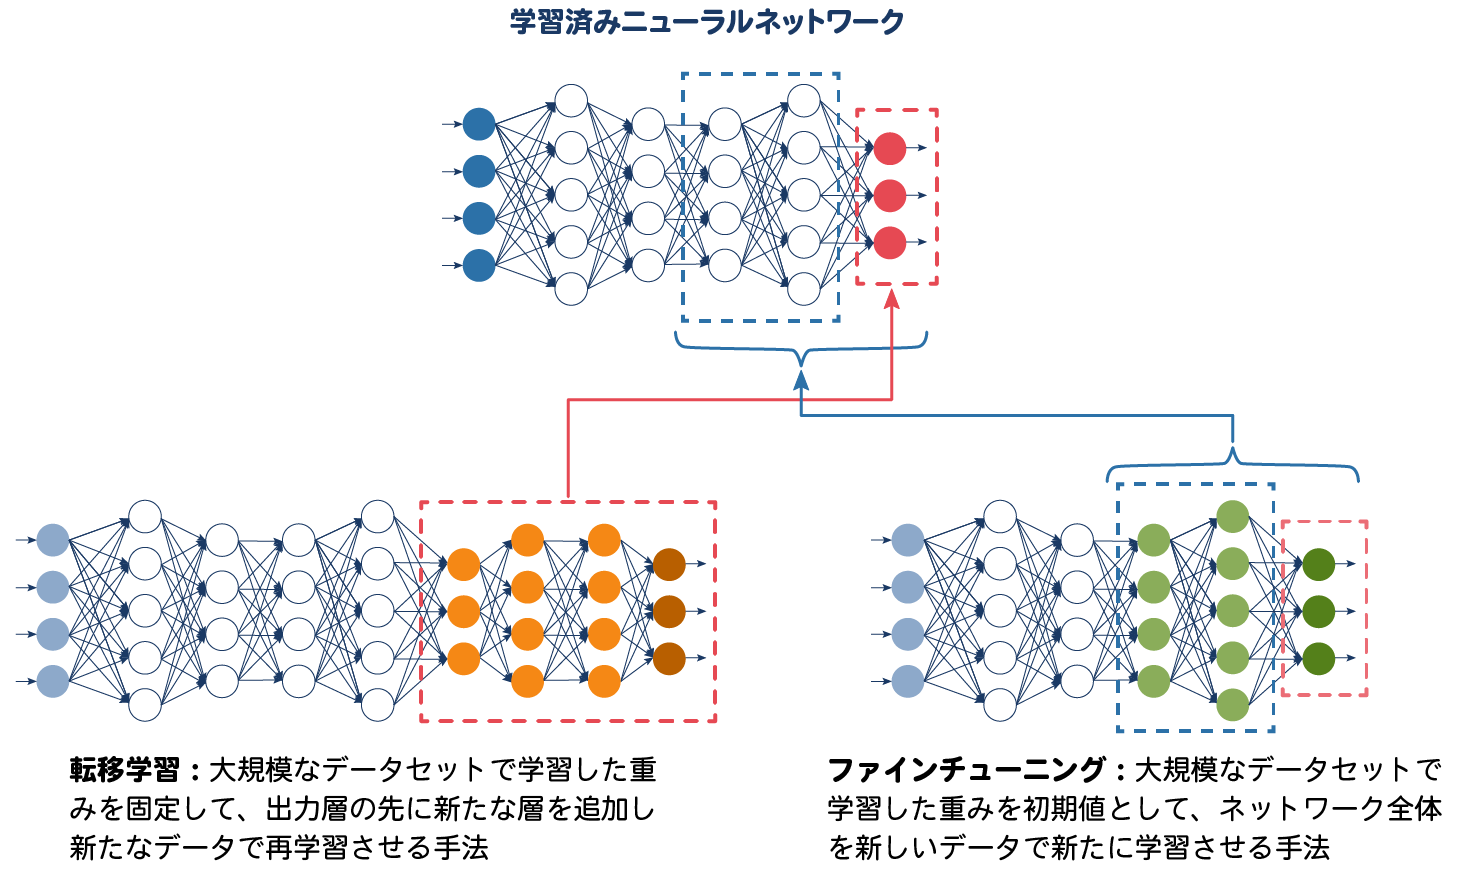

## モジュールのインポート

In [ ]:
import os
from tqdm.notebook import tqdm
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchsummary import summary
from torchvision import datasets, models, transforms

## 利用するデータセットの読み込み
今回、pytorchのチュートリアルにも採用されているアリとハチの2クラス分類用のデータセットを利用します。      
このデータセットには、アリとハチのそれぞれについて、約120枚の訓練画像(train)と各クラス75枚の評価用画像(val)が含まれています。      
通常、このような少ない枚数のデータセットだけでは、ゼロからモデルを訓練して十分な性能を得るのは難しいです。      
しかし、今回は少量の画像データからでも高い精度を出せる可能性がある転移学習を活用する予定なので、このデータセットの量でも良好な精度を実現することが期待できます。    

In [ ]:
# データセットのダウンロード
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2023-09-20 02:40:31--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.38.96, 99.86.38.106, 99.86.38.72, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.38.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   115MB/s    in 0.4s    

2023-09-20 02:40:31 (115 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/

## データ拡張の設定と読み込み
データ拡張の設定を行います。  
訓練データに対しては、ランダムリサイズクロップ(transforms.RandomResizedCrop(224))と、  
ランダムに画像を水平反転(transforms.RandomHorizontalFlip())する処理を適用します。  
さらに、画像の各チャンネルに対して正規化を行います。  

検証データに対しては、画像のリサイズ(transforms.Resize(256))と中央クロップ(transforms.CenterCrop(224))を行い、  
同様に正規化を適用します。

In [ ]:
# データの前処理設定

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2) for x in ['train', 'val']}

## 学習に使うデータの確認

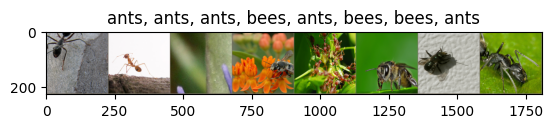

In [ ]:
# データセットからクラス名を取得
class_names = image_datasets['train'].classes

# テンソル形式の画像を表示するための関数
def imshow(inp, title=None):

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# 訓練データから画像とラベルを取得
inputs, classes = next(iter(dataloaders['train']))

# ラベル名を取得
labels = [class_names[cls] for cls in classes]

# 画像を表示するためにグリッドを作成
out = torchvision.utils.make_grid(inputs)

# 画像とラベル名を表示
imshow(out, title=", ".join(labels))

## 自作モデルの作成
このモデルは、転移学習モデルとの比較のために作成した自作のものです.  
モデルの構造は、4層の畳み込み層(nn.Conv2d)とそれぞれの層に対応するバッチ正規化(nn.BatchNorm2d)から成り立っており、これらの層の後に2×2のMaxPoolingが適用されています.    
畳み込み層を通過した後、3層の全結合層(nn.Linear)を経由します.1つ目と2つ目の全結合層の間にはドロップアウトが導入されています  
また、畳み込み層および全結合層の活性化関数としてReLU関数が使用されています.



In [ ]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 14 * 14, 1024)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = x.view(-1, 128 * 14 * 14)

        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

custom_model = CustomModel().to(device)

In [ ]:
# 自作モデルの構造の表示
summary(custom_model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
       BatchNorm2d-5         [-1, 32, 112, 112]              64
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
       BatchNorm2d-8           [-1, 64, 56, 56]             128
         MaxPool2d-9           [-1, 64, 28, 28]               0
           Conv2d-10          [-1, 128, 28, 28]          73,856
      BatchNorm2d-11          [-1, 128, 28, 28]             256
        MaxPool2d-12          [-1, 128, 14, 14]               0
           Linear-13                 [-1, 1024]      25,691,136
          Dropout-14                 [-

## 事前学習済みモデルの読み込みと最終層のカスタマイズ
学習済みモデルにはResNet18を利用します.  
models.resnet18(pretrained=True)のresnet18の部分を変更することで他のモデルを利用することができます.  

torchvisionで使えるモデル集   
https://pytorch.org/vision/0.8/models.html

また、pretrained=TrueにするとImageNetで学習したモデルを利用できます.    
ImageNetは1000クラスのデータセットとなっているため、ImageNetで学習したResNet18の出力層のユニット数も1000になっています．  
今回転移学習に利用するデータセットはハチとアリの２クラスなので、出力層のユニット数を2に変更します.    

In [ ]:
# 事前学習済みモデル (ResNet-18)
pretrained_model = models.resnet18(pretrained=True)
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, 2) #　出力のユニット数をデータに合わせて２に設定
model_pretrained = pretrained_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# 出力層以外のすべてのパラメータを固定
for param in pretrained_model.parameters():
  param.requires_grad = False

# 最後の全結合層のパラメータのみを学習可能にする
for param in pretrained_model.fc.parameters():
    param.requires_grad = True

In [ ]:
# 事前学習済みモデルの構造を表示
summary(model_pretrained,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

summaryの出力結果からモデルのパラメータ数を確認することができます。  
今回は転移学習を行うため、最後の全結合層の1,026のパラメータだけを学習します。

- Total params (モデルの合計パラメータ数): 11,177,538
- Trainable params (学習によって更新されるパラメータ数): 1,026
- Non-trainable params (固定されているパラメータ数): 11,176,512

## 損失関数とオプティマイザの設定
- 今回は分類問題のため、損失関数にはCrossEntropyLossを使用しています
- 条件を同じにするため、自作モデルと転移学習のモデルのオプティマイザ(最適化手法)にはAdamを使用しています

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_pretrained = optim.Adam(pretrained_model.parameters(), lr=0.001)
optimizer_custom = optim.Adam(custom_model.parameters(), lr=0.001)

## 学習回数の設定

In [ ]:
num_epochs = 10

## 学習用関数の定義
モデルの学習を行う関数train_modelを定義します。  
この関数は、学習に使用するモデル、データローダ、損失関数、最適化手法、エポック数、および実行デバイスを引数として受け取ります。

指定したエポック数にわたり、ミニバッチごとにモデルの予測を行い、  
その予測と実際のラベルとの間の誤差を計算し、計算された誤差を逆伝播してネットワークを更新します。  

学習の進行状況はtqdmを使用して表示され、各エポックの平均損失と認識精度を表示します。  
関数の返り値として、全エポックを通じた損失と精度の履歴を返します。

In [ ]:
def train_model(model, dataloader, criterion, optimizer, num_epochs, device):
    loss_history = []
    acc_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=False)
        for i, (inputs, labels) in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            loop.set_description(f"Epoch [{epoch + 1}/{num_epochs}]")
            loop.set_postfix(loss=running_loss/(i+1))

        average_loss = running_loss / len(dataloader)
        accuracy = 100 * correct / total

        loss_history.append(average_loss)
        acc_history.append(accuracy)
        print(f'Epoch {epoch + 1} , "Loss": {average_loss:.4f} , "Accuracy": {accuracy:.4f}')

    return loss_history, acc_history

## 自作モデルの学習

In [ ]:
loss_history_custom, acc_history_custom = train_model(custom_model, dataloaders['train'], criterion, optimizer_pretrained, num_epochs, device)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1 , "Loss": 0.7064 , "Accuracy": 46.7213


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2 , "Loss": 0.7113 , "Accuracy": 47.9508


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3 , "Loss": 0.7107 , "Accuracy": 45.0820


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4 , "Loss": 0.6980 , "Accuracy": 54.5082


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 , "Loss": 0.7021 , "Accuracy": 49.1803


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6 , "Loss": 0.7002 , "Accuracy": 48.3607


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7 , "Loss": 0.6977 , "Accuracy": 51.2295


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8 , "Loss": 0.7025 , "Accuracy": 48.7705


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9 , "Loss": 0.6931 , "Accuracy": 51.2295


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10 , "Loss": 0.6981 , "Accuracy": 50.8197


## 事前学習済みモデルの学習

In [ ]:
loss_history_pretrained, acc_history_pretrained = train_model(pretrained_model, dataloaders['train'], criterion, optimizer_pretrained, num_epochs, device)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1 , "Loss": 0.6977 , "Accuracy": 51.2295


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2 , "Loss": 0.7021 , "Accuracy": 50.0000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3 , "Loss": 0.7058 , "Accuracy": 50.0000


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4 , "Loss": 0.7133 , "Accuracy": 48.7705


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 , "Loss": 0.7010 , "Accuracy": 50.4098


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6 , "Loss": 0.7064 , "Accuracy": 51.2295


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7 , "Loss": 0.7049 , "Accuracy": 48.3607


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8 , "Loss": 0.7071 , "Accuracy": 49.5902


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9 , "Loss": 0.7057 , "Accuracy": 51.2295


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10 , "Loss": 0.7082 , "Accuracy": 50.8197


## 自作モデルと事前学習済みモデルの精度の比較
- 自作モデルではデータ数が少ないため、学習を進めても損失が下がらず、精度（Accuracy）も向上しないことが確認できます。
- これに対して、転移学習を使用したモデルでは精度（Accuracy）が90%近くに達しており、少量のデータでの学習にも効果があることが確認できます。

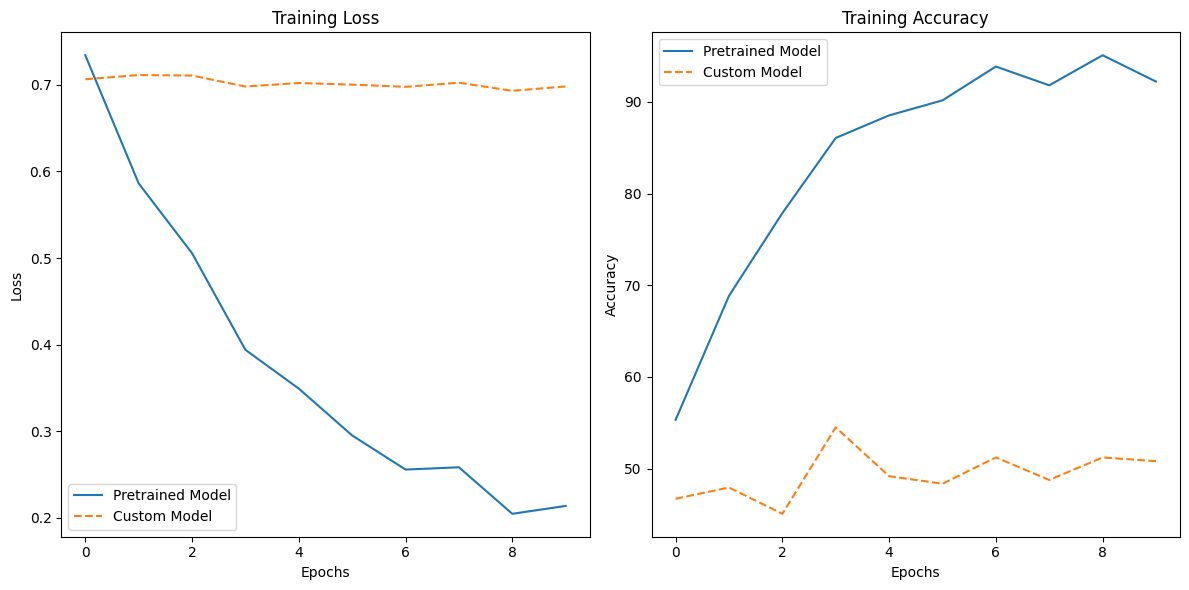

In [ ]:
# 損失のグラフ
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_history_pretrained, label='Pretrained Model')
plt.plot(loss_history_custom, label='Custom Model', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# 精度のグラフ
plt.subplot(1, 2, 2)
plt.plot(acc_history_pretrained, label='Pretrained Model')
plt.plot(acc_history_custom, label='Custom Model', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

学習した自作モデルと転移学習モデルを、学習に使用していないdataloaders['val']のデータを用いて精度を評価します

In [ ]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    average_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total

    return average_loss, accuracy

# 自作モデルの評価
loss_custom, acc_custom = evaluate_model(custom_model, dataloaders['val'], criterion, device)
print(f"Custom Model - Loss: {loss_custom:.4f}, Accuracy: {acc_custom:.4f}%")

# 事前学習済みモデルの評価
loss_pretrained, acc_pretrained = evaluate_model(pretrained_model, dataloaders['val'], criterion, device)
print(f"Pretrained Model - Loss: {loss_pretrained:.4f}, Accuracy: {acc_pretrained:.4f}%")

Custom Model - Loss: 0.6924, Accuracy: 50.9804%
Pretrained Model - Loss: 0.1729, Accuracy: 96.0784%


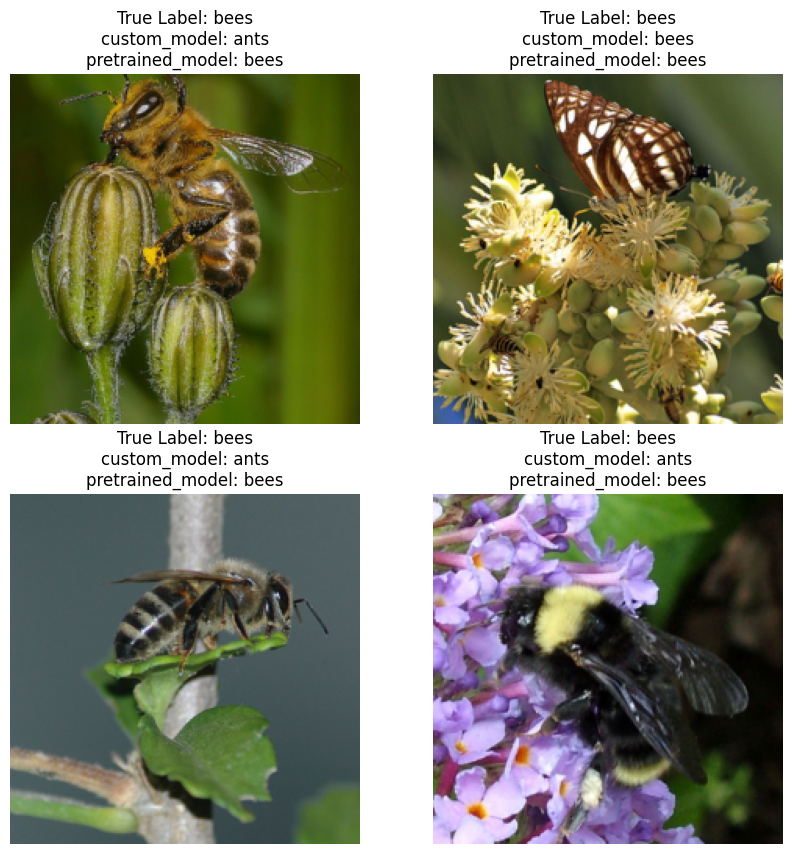

In [ ]:
# 予測ラベルと正解画像を表示するための関数

def visualize_predictions(models, model_names, dataloader, device, num_images=4):
    # モデルを評価モードに設定
    for model in models:
        model.eval()

    # 画像とラベルをロード
    images_so_far = 0
    plt.figure(figsize=(10, 10))
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = [model(inputs) for model in models]
            preds = [torch.argmax(output, 1) for output in outputs]

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                true_label = dataloaders["val"].dataset.classes[labels[j]]
                title = [f'{model_names[k]}: {dataloaders["val"].dataset.classes[pred[j]]}' for k, pred in enumerate(preds)]
                title.insert(0, f'True Label: {true_label}')
                ax.set_title("\n".join(title))
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                plt.imshow(img)

                if images_so_far == num_images:
                    return

# 評価モデルのリストを使用して画像を表示
visualize_predictions([custom_model, model_pretrained], ["custom_model", "pretrained_model"], dataloaders, device)

# 課題
1. 他のモデルで転移学習を行ってみて精度がどのように変化するか確かめてみましょう

In [ ]:
# ここにコードを実装


2. 転移学習では、事前に学習されたモデルの出力層を除くすべての層のパラメータを固定し、出力層のみを新しいデータセットに合わせて学習します.  一方、ファインチューニングでは、事前に学習されたモデルのすべての層のパラメータを新しいデータセットに合わせて再学習します.  

下記のコードのfor文の部分をコメントアウトし再度学習を行い、転移学習とファインチューニングの違いを実際に体験してみましょう.  

In [ ]:
# 転移学習のために出力層以外のパラメータを全て固定している

# 出力層以外のすべてのパラメータを固定
for param in pretrained_model.parameters():
  param.requires_grad = False

# 最後の全結合層のパラメータのみを学習可能にする
for param in pretrained_model.fc.parameters():
    param.requires_grad = True

In [ ]:
# ここにコードを実装


3. 任意のモデルで学習済みモデルを利用する場合としない場合での精度を比較してみましょう

In [ ]:
# ここにコードを実装
